
# (some) Related Work
- see Brownian motion link in literature folder
- https://en.wikipedia.org/wiki/Schwarz_alternating_method
# abstract
We discuss some boundary value algorithms and first passage sampling algoritms.

# Boundary Value Problems
In period2 we solved a boundary problem using Green functions. Our goal for the next period is to get an implementation of unbiased $1$ D BVP solver of higher order. In the following we implement different BVP  algorithms for
$$
y''=y, y(-1) = e^{-1},y(1)=e .
$$

## Preparation
For those algorithms we need the corresponding Green functions of this problem.

### boundary green function of $y''$

$$
\begin{align*}
G''_{b_{0}}(t) &= 0, G(b_{0})=1,G(b_{1})=0 \Rightarrow \\
G_{b_{0}}(t) &= \frac{b_{1}-t}{b_{1}-b_{0}} \\   
\end{align*}
$$ 
$$
\begin{align*}
G''_{b_{1}}(t) &= 0, G(b_{0})=0,G(b_{1})=1 \Rightarrow \\
G_{b1}(t) &= \frac{t-b_{0}}{b_{1} -b_{0}}
\end{align*}
$$


### source green function of $y''$
$$
\begin{align*}
G''_{s}(t) &= \delta(t-s), G(b_{0})=0,G(b_{1})=0 \Rightarrow \\
G_{s}(t) &=    \begin{cases}
        -\frac{(b_{1}-s)(t-b_{0})}{b_{1}-b_{0}} & \text{if } t<s\\
        -\frac{(b_{1}-t)(s-b_{0})}{b_{1}-b_{0}} & \text{if } s<t
    \end{cases} \\
G_{t}(s) &=    \begin{cases}
        -\frac{(b_{1}-t)(s-b_{0})}{b_{1}-b_{0}} & \text{if } s<t\\
        -\frac{(b_{1}-s)(t-b_{0})}{b_{1}-b_{0}} & \text{if } t<s
    \end{cases}
\end{align*} 
$$ 

### testing the green function
We solve
$$
y''= y,y(b_{0}), y(b_{1}).
$$ 
the same way as in period2 to test these green functions are correct

In [35]:
from random import random
from math import exp
import numpy as np

def Gb0(t,b0,b1): return (b1-t)/(b1-b0)
def Gb1(t,b0,b1): return (t-b0)/(b1-b0)
def G(t,s,b0,b1): return -(b1-s)*(t-b0)/(b1-b0) if t<s else - (b1-t)*(s-b0)/(b1-b0) 

def Y(t,y0,y1,b0,b1): 
    l = 2 # russian roulette rate
    if random()*l>1: return Gb0(t,b0,b1)*y0 + Gb1(t,b0,b1)*y1
    S = b0+random()*(b1-b0)
    return Gb0(t,b0,b1)*y0 + Gb1(t,b0,b1)*y1 + l*G(t,S,b0,b1) * Y(S,y0,y1,b0,b1)*(b1-b0)
    
def soltest(t,y0,y1,b0,b1,nsim): return sum(Y(t,y0,y1,b0,b1) for _ in range(nsim))/nsim

nsim = 10**2
B0 = np.arange(-1,0,0.2)
B1 = np.arange(1,0,-0.2)
T = [b0+(b1-b0)*random() for b0,b1 in zip(B0,B1) ]

for t,b0,b1 in zip(T,B0,B1):
    print((soltest(t,exp(b0),exp(b1),b0,b1,nsim)-exp(t))/exp(t))


print(20*"-")
nsim = 10**2
B0 = list(np.arange(-5,-1,1)) + [-0.5]
B1 = list(np.arange(5,1,-1)) + [0.5]
T = [0]*len(B0)

for t,b0,b1 in zip(T,B0,B1):
    print((soltest(t,exp(b0),exp(b1),b0,b1,nsim)-exp(t))/exp(t))

-0.0018638868854634976
-0.025637354041806625
0.00017375710771098764
-0.004524584230283205
-4.5991071141950004e-05
--------------------
-20738.633867881206
-35742327.632631265
22405.08658446475
151.02439455439716
0.02947680913390549


## WoS (Walk on Sphere)

The idea of walk on sphere is to use the integral equation corresponding to the largest sphere around $t$ contained in the domain:
![WoS](tests_period_5/tikz%20figures/WoS/WoS.png)
$$
y(t) = G_{h_{0}}(t)y_{h_{0}} + G_{h_{1}}(t) y_{h_{1}} + \int_{h_{0}}^{h_{1}} G_{t}(s)y(s)ds 
$$ 
with $h_{0},h_{1}$ the points of the biggest sphere with midpoint $t$. In the $1$ dimensional case is either $h_{0}=b_{0}$ or $h_{1}=b_{1}$. Meaning we're still left with 
additive branching recursion. To get rid of this we couple the Russian roulette of these
terms such that there is no branching. <br>

Here is a nasty implementation of this:

In [117]:
from random import random
from math import exp
from numba import njit, prange

@njit(fastmath =True)
def Gb0(t,b0,b1): return (b1-t)/(b1-b0)
@njit(fastmath =True)
def Gb1(t,b0,b1): return (t-b0)/(b1-b0)
@njit(fastmath =True)
def G(t,s,b0,b1): return -(b1-s)*(t-b0)/(b1-b0) if t<s else - (b1-t)*(s-b0)/(b1-b0) 

@njit(fastmath =True)
def Yws(t):
    if t==-1: return exp(-1)
    if t==1: return exp(1)

    if t+1<1-t: 
        h0,h1 = -1,2*t+1
        if random()<0.5:
            return Gb0(t,h0,h1)*Yws(h0)+ 2*Gb1(t,h0,h1)*Yws(h1)
        elif random()<0.5:
            S = h0+random()*(h1-h0)
            return Gb0(t,h0,h1)*Yws(h0)+ 4*G(t,S,h0,h1) * Yws(S)*(h1-h0)
        else:
            return Gb0(t,h0,h1)*Yws(h0)
    else:
        h0,h1 = 2*t-1,1
        if random()<0.5:
            return 2*Gb0(t,h0,h1)*Yws(h0) + Gb1(t,h0,h1)*Yws(h1)
        elif random()<0.5:
            S = h0+random()*(h1-h0)
            return Gb1(t,h0,h1)*Yws(h1) + 4*G(t,S,h0,h1) * Yws(S)*(h1-h0)
        else:
            return Gb1(t,h0,h1)*Yws(h1)

@njit(fastmath=True, parallel=True)
def wssol(t,nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Yws(t)
    return total/nsim

In [179]:
t,nsim = 0.4,10**5
print((wssol(t,nsim)-exp(t))/exp(t))

0.0016335495054296664


The advantage of Walk on Sphere is that it doesn't need the full Green functions and there is no worrying about meshing.

## Coupled Splitting

$$
\begin{align*}
y(t) &= G_{b_{0}}(t)y_{b_{0}} + G_{b_{1}}(t) y_{b_{1}} + \int_{b_{0}}^{b_{1}} G_{t}(s)f(s)ds \\
 &= G_{b_{0}}(t)y_{b_{0}} + G_{b_{1}}(t) y_{b_{1}} 
 + \int_{b_{0}}^{l} G_{t}(s)f(s)ds + \int_{l}^{b_{1}} G_{t}(s)f(s)ds  .
\end{align*}
$$

We do coupled recursion on those $2$ integral for 
$$
y''=y, y(-1)=e^{-1},y(1)=e.
$$ 
this gives the following nice matrix recursion:

$$
X(t_{1},t_{2})=
\begin{bmatrix} 
G_{b_{0}}(t_{1}) & G_{b_{1}}(t_{1})\\
G_{b_{0}}(t_{2}) & G_{b_{1}}(t_{2})
\end{bmatrix} 
\begin{bmatrix} 
y(b_{0})\\
y(b_{1})
\end{bmatrix} 
+
\begin{bmatrix} 
G_{t_{1}}(U_{1}) & G_{t_{1}}(U_{2}) \\
G_{t_{2}}(U_{1}) & G_{t_{2}}(U_{2}) 
\end{bmatrix}
\begin{bmatrix} 
f_{U_{1}}(U_{1}) & 0 \\
0                & f_{U_{2}}(U_{2}) 
\end{bmatrix}
X(U_{1},U_{2})
$$ 
where $U_{1} = \text{Uniform}(b_{0},l), U_{2} = \text{Uniform}(l,b_{1})$. We implement this with russian roulette:

In [187]:
from random import random
from math import exp
import numpy as np

def Gb0(t,b0,b1): return (b1-t)/(b1-b0)
def Gb1(t,b0,b1): return (t-b0)/(b1-b0)
def G(t,s,b0,b1): return -(b1-s)*(t-b0)/(b1-b0) if t<s else - (b1-t)*(s-b0)/(b1-b0) 

def Xrec(t1,t2):
    l = 2
    if random()*l>1: return np.zeros(2) 
    S1,S2 = random()-1,random()
    X = Xrec(S1,S2)
    x0 = Gb0(t1,-1,1)*exp(-1) + Gb1(t1,-1,1)*exp(1) 
    x0 += G(t1,S1,-1,1)*X[0] + G(t1,S2,-1,1)*X[1]
    x1 = Gb0(t2,-1,1)*exp(-1) + Gb1(t2,-1,1)*exp(1) 
    x1 += G(t2,S1,-1,1)*X[0] + G(t2,S2,-1,1)*X[1]
    return l*np.array([x0,x1])

def solrec(t1,t2,nsim): return sum(Xrec(t1,t2) for _ in range(nsim))/nsim

print(solrec(-0.5,0.3,10**3))
print(exp(-0.5),exp(0.3))


[0.59564983 1.29340874]
0.6065306597126334 1.3498588075760032


## alternating RRMC

We demonstrate alternating RRMC on a grid with $3$ points $[-0.5,0,0.5]$.
The idea is to use local integral representation on overlapping domains
to repeatably do coupled RMC to estimate the solution on the grid. <br> 

![alternating RRMC](tests_period_5/tikz%20figures/local%20RRMC/local%20RRMC.png)

We will implement this with recursion in recursion. The outer recursion is a coupled recursion of $3$ points and the inner recursion is just regular RMC where we assume we know the value at adjacent points. This is like walk on rectangle and Schwarz alternating method.

In [1]:
from random import random
from math import exp
import numpy as np

def Gb0(t,b0,b1): return (b1-t)/(b1-b0)
def Gb1(t,b0,b1): return (t-b0)/(b1-b0)
def G(t,s,b0,b1): return -(b1-s)*(t-b0)/(b1-b0) if t<s else - (b1-t)*(s-b0)/(b1-b0) 

def Y(t,y0,y1,b0,b1): 
    l = 2 # russian roulette rate
    if random()*l>1: return Gb0(t,b0,b1)*y0 + Gb1(t,b0,b1)*y1
    S = b0+random()*(b1-b0)
    return Gb0(t,b0,b1)*y0 + Gb1(t,b0,b1)*y1 + l*G(t,S,b0,b1) * Y(S,y0,y1,b0,b1)*(b1-b0)

def X_slow():
    l = 1.5 # russian roulette rate
    if random()*l>1: return  np.zeros(3)
    X = X_slow()
    x0 = Y(-0.5,exp(-1),X[1],-1,0)
    x1 = Y(0,X[0],X[2],-0.5,0.5)
    x2 = Y(0.5,X[1],exp(1),0,1) 
    return l*np.array([x0,x1,x2]) 

def soltest2(nsim): return sum(X_slow() for _ in range(nsim))/nsim
grid = np.array([-0.5,0,0.5])
nsim = 10**4
sol = np.exp(grid)
ss = soltest2(nsim)
print(f"soltest2= {ss}, %error{(ss-sol)/sol}")

soltest2= [0.60032936 0.99434167 1.63228269], %error[-0.01022421 -0.00565833 -0.00997051]


## Remark
The ideas in the last $3$ algorithms may be combined. It is for example possible to
do WoS inside the local domains of local RRMC.

# Brownian Motion

## Introduction 

### Definition
Define Brownian motion $W_{t}$ as the limit/logical generalization 
when $n \rightarrow \infty$ of following discrete proces defined as:
$$
\begin{cases}
    X_{t}^{n} = X_{t-\frac{1}{n}}^{n} + Z_{n} \\ 
    X^{n}_{0}=0
\end{cases}.
$$ 
With $Z_{n}\sim N(0,\frac{1}{n})$ i.i.d . From this definition it is easily seen that
$W_{t} \sim N(0,t)$. 

### Self-affinity
Brownian motion is self affine as a random proces that means you can cut a small part of it move so it starts in $0$ and scale time to the original size and space such that the variance stays the same to get back the whole Brownian motion. 
$$
\forall c \in \mathbb{R}^{+}_{0}: \frac{W_{ct}}{\sqrt{c}} \sim W_{t}.
$$ 
### Feyman Kac Formula (wikipedia)

Consider the partial differential equation
$$
\frac{\partial u}{\partial t}(x, t)+\mu(x, t) \frac{\partial u}{\partial x}(x, t)+\frac{1}{2} \sigma^2(x, t) \frac{\partial^2 u}{\partial x^2}(x, t)-V(x, t) u(x, t)+f(x, t)=0,
$$
defined for all $x \in \mathbb{R}$ and $t \in[0, T]$, subject to the terminal condition
$$
u(x, T)=\psi(x),
$$
where $\mu, \sigma, \psi, V, f$ are known functions, $T$ is a parameter, and $u: \mathbb{R} \times[0, T] \rightarrow \mathbb{R}$ is the unknown. Then the Feynman-Kac formula tells us that the solution can be written as a conditional expectation
$$
u(x, t)=E^Q\left[\int_t^T e^{-\int_t^r V\left(X_\tau, \tau\right) d \tau} f\left(X_r, r\right) d r+e^{-\int_t^T V\left(X_\tau, \tau\right) d \tau} \psi\left(X_T\right) \mid X_t=x\right]
$$
under the probability measure $Q$ such that $X$ is an Itô process driven by the equation
$$
d X_t=\mu(X, t) d t+\sigma(X, t) d W_t^Q
$$
with $W^Q(t)$ is a Wiener process (also called Brownian motion) under $Q$, and the initial condition for $X(t)$ is $X(t)=x$.

## First Passage Sampling
In the first passage sampling we try to sample state when a proces reaches a boundary or specified state of the system for the first time (the first passage). We are specifically interested in 
first passage problem with Brownian motion for a closed time space barrier. The first passage distribution of Brownian motion is in fact the boundary green function for the heat equation this can be easily seen by using the Feynman-Kac formula.
### Euler Frist Passage Sampling 
In the following example we use the Euler scheme to approximately sample first passages of a triangle and a parabola.

#### Triangle Example

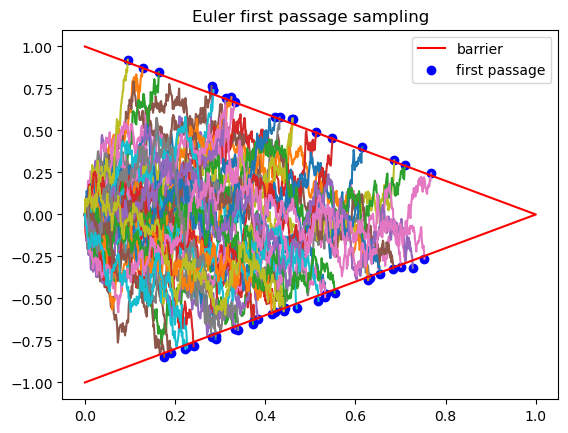

In [180]:
import numpy as np
import matplotlib.pyplot as plt

def in_triangle(time,pos): return 1-time > abs(pos)   
        
nsim = 10*5
dt = 0.001
for _ in range(nsim):
    pos,time = 0,0
    path = [(time,pos)]
    while in_triangle(time,pos):
        pos += np.random.normal(0, 1) * np.sqrt(dt)
        time +=  dt
        path.append((time,pos))
    T,X = zip(*path)
    plt.plot(T,X)
    plt.scatter(time,pos,color="blue") 


x = [0,1,0]
y = [1,0,-1]
plt.plot(x,y,color="red",label="barrier")
plt.scatter([],[],color="blue",label="first passage")
plt.title("Euler first passage sampling")
plt.legend()
plt.show()

#### Parabola Example

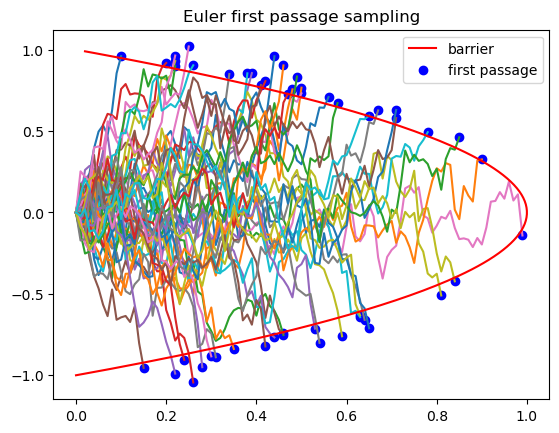

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def in_para(time,pos): return 1-time > abs(pos)**2
        
nsim = 10*5
dt = 0.01
for _ in range(nsim):
    pos,time = 0,0
    path = [(time,pos)]
    while in_para(time,pos):
        pos += np.random.normal(0, 1) * np.sqrt(dt)
        time +=  dt
        path.append((time,pos))
    T,X = zip(*path)
    plt.plot(T,X)
    plt.scatter(T[-1],X[-1],color="blue") 


y = np.arange(-1,1,0.01)
x = 1-y**2

plt.plot(x,y,color="red",label="barrier")
plt.scatter([],[],color="blue",label="first passage")
plt.title("Euler first passage sampling")
plt.legend()
plt.show()

### Recursive First Passage Sampling
The idea behind recursive first passage sampling is to break down a first passage sampling on a bigger domain to contained smaller domains by using the fact you can't leave the big domain without leaving the smaller first (intermediate value theorem). When you sample the exit from the smaller domain it is start point of a new first passage sampling problem and you can recurse until you close to the stopping condition. <br>

Incorporating jumps doesn't look difficult (see Exact simulation of the first passage time through a given level for jump diffusions and other references that use this technique). <br>

#### Base Samples
To start of you need to be able to simulate exit from smaller domains efficiently.
We for example resample from the Euler first passage sample on a triangle and rescale the problem to multiple domains using self affinity of Brownian Motion. Alternatively you can tabloid the inverse cumulative density function and also abuse symmetries. (see The Simulation–Tabulation Method for Classical Diffusion Monte Carlo)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def in_triangle(time,pos): return 1-time > abs(pos)   

def euler_triangle_sample(dt=0.1,nsim=10**3):
    sample = []
    for _ in range(nsim):
        pos,time = 0,0
        while in_triangle(time,pos):
            pos += np.random.normal(0, 1) * np.sqrt(dt)
            time +=  dt
        sample.append((time,pos))
    return sample

tsample = euler_triangle_sample(0.001,10**4) 

#### Example Parabola
Here we implement recursive first passage sampling for a parabola. We chose to rescale our base sample such that it nearly fits inside the parabola.

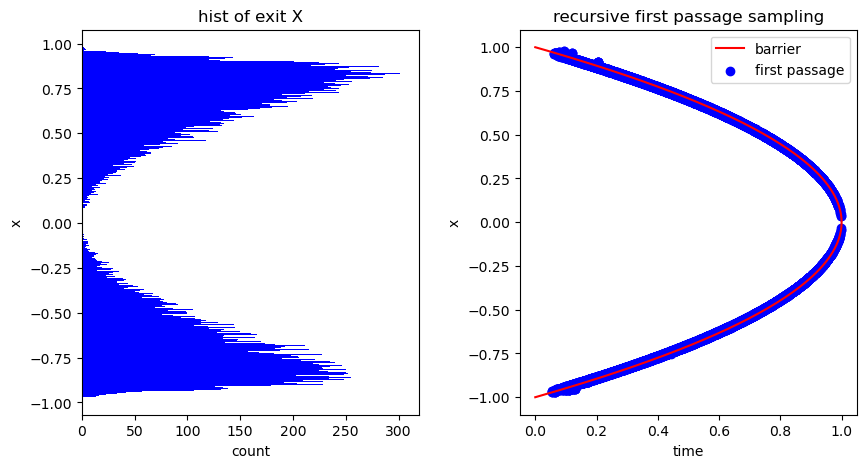

In [16]:
from math import sqrt
import random

def triangle_scale(time,pos):
        xx = sqrt(1-time)- abs(pos)
        tt = abs(1-abs(pos)**2-time)
        return sqrt(tt) if sqrt(tt)<xx else xx

def recursive_para_sample(nsim = 10**3,accuracy = 0.1,scale_mul = 1):
    sample = []
    for _ in range(nsim):
        pos,time= 0,0
        scale = triangle_scale(time,pos)*scale_mul
        while scale > accuracy:
            dtime,dpos = random.sample(tsample,1)[0]
            dtime,dpos = (scale**2)*dtime,scale*dpos
            pos += dpos
            time += dtime
            scale = triangle_scale(time ,pos)
        sample.append((time,pos))
    return sample

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

y = np.arange(-1,1.01,0.01)
x = 1 - y**2
axs[1].plot(x, y, color="red", label="barrier")

rsample = recursive_para_sample(5*10**4,0.01,1)
T,X = zip(*rsample)
axs[1].scatter(T,X,alpha = 1,color = "blue")

# Plot the scatter plot on the right
axs[1].scatter([], [], color="blue", label="first passage")
axs[1].set_title("recursive first passage sampling")
axs[1].set_xlabel("time")
axs[1].set_ylabel("x")
axs[1].legend()

# Plot the histogram on the left
axs[0].hist(X, bins=500, orientation="horizontal", color="blue")
axs[0].set_title("hist of exit X")
axs[0].set_ylabel("x")
axs[0].set_xlabel("count")

plt.subplots_adjust(wspace=0.3)
plt.show()


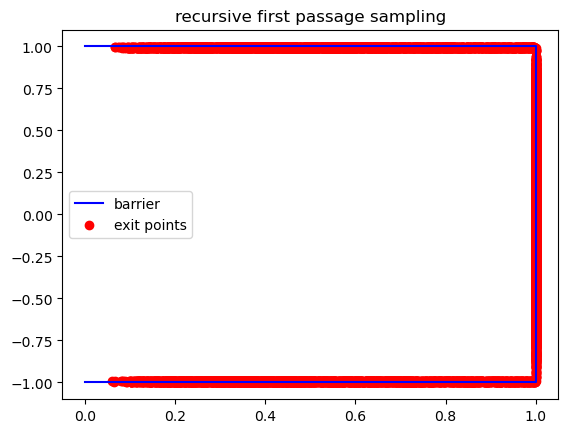

In [18]:
from math import sqrt
import random


def rectangle_scale(time,pos):
    xx= 1-abs(pos) 
    tt = abs(1-time)
    return sqrt(tt) if sqrt(tt)<xx else xx

def recursive_rec_sample(nsim = 10**3,accuracy = 0.1):
    sample = []
    for _ in range(nsim):
        pos,time= 0,0
        scale = rectangle_scale(time,pos)
        while scale > accuracy:
            dtime,dpos = random.sample(tsample,1)[0]
            dtime,dpos = (scale**2)*dtime,scale*dpos
            pos += dpos
            time += dtime
            scale = rectangle_scale(time ,pos)
        sample.append((time,pos))
    return sample
rsample = recursive_rec_sample(10**4,0.01)

T,X = zip(*rsample)
plt.scatter(T,X,alpha = 1,color ="red")

x = [0,1,1,0]
y = [1,1,-1,-1]
plt.plot(x,y,color="blue",label="barrier")

plt.scatter([],[],color="red",label="exit points")
plt.title("recursive first passage sampling")
plt.legend()
plt.show()

You can transform first passage sampling problems for others processes back to Brownian Motion by doing the right time and space bending. For example geometric Brownian motion can be made into Brownian motion by taking the log.

Sometimes we're interested in a specific property of a first passage sampled path like the max or the average. The naif way would be sampling full paths and calculating the desired property instead you can sample only the required information to calculate the desired property. In the case of the max and the average for example you only need the sample the max/average of the subpaths and combined that to the max/average of the whole path. <br>

#### Base Average Samples 
In the case of Brownian motion the max and the average have some nice symmetries that transform well with our base sample.

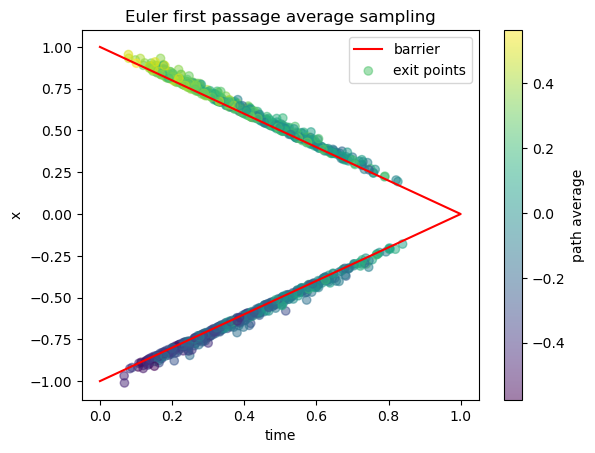

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def in_triangle(time,pos): return 1-time > abs(pos)   

def euler_triangle_average_sample(dt=0.1,nsim=10**3):
    average_sample = []
    for _ in range(nsim):
        pos,time,average,num = 0,0,0,0
        while in_triangle(time,pos):
            pos += np.random.normal(0, 1) * np.sqrt(dt)
            time +=  dt
            num+=1
            average+=pos
        average_sample.append((time,pos,average/num))
    return average_sample


x = [0,1,0]
y = [1,0,-1]
plt.plot(x,y,color="red",label="barrier")

t_average_sample = euler_triangle_average_sample(0.001,10**3) 
x,y,c = zip(*t_average_sample)
plt.scatter(x,y,c=c,cmap="viridis",alpha=0.5,label="exit points")
plt.colorbar(label="path average")
plt.xlabel("time")
plt.ylabel("x")
plt.title("Euler first passage average sampling")
plt.legend()
plt.show()

#### Parabola Average Example

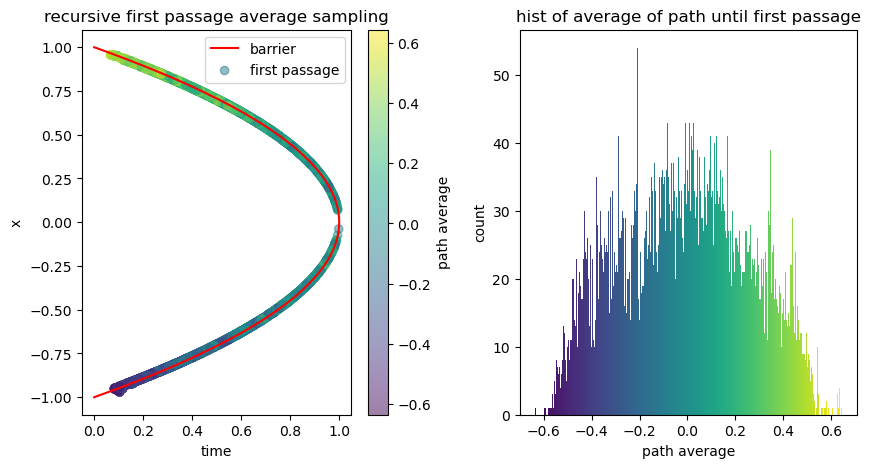

In [11]:
from math import sqrt
import random

def triangle_scale(time,pos):
        xx = sqrt(1-time)- abs(pos)
        tt = abs(1-abs(pos)**2-time)
        return sqrt(tt) if sqrt(tt)<xx else xx

def recursive_para_average_sample(nsim = 10**3,accuracy = 0.1):
    average_sample = []
    for _ in range(nsim):
        pos,time,average = 0,0,0
        scale = triangle_scale(time,pos)
        while scale > accuracy:
            dtime,dpos,daverage = random.sample(t_average_sample,1)[0]
            dtime,dpos,daverage = (scale**2)*dtime,scale*dpos,pos+scale*daverage
            pos += dpos
            time += dtime
            average+=daverage*dtime
            scale = triangle_scale(time ,pos)
        average_sample.append((time,pos,average/time))
    return average_sample

y = np.arange(-1,1.01,0.01)
x = 1 - y**2
r_average_sample = recursive_para_average_sample(10**4,0.01) 
x_r, y_r, c_r = zip(*r_average_sample)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first plot on the left subplot
axs[0].plot(x, y, color="red", label="barrier")
sc = axs[0].scatter(x_r, y_r, c=c_r, cmap="viridis", alpha=0.5, label="first passage")
cbar = plt.colorbar(sc, ax=axs[0], label="path average")
axs[0].set_xlabel("time")
axs[0].set_ylabel("x")
axs[0].set_title("recursive first passage average sampling")
axs[0].legend()

# Plot the second plot on the right subplot
bin_edges = np.linspace(np.min(c_r), np.max(c_r), 501)
bin_width = bin_edges[1] - bin_edges[0]
colors = plt.cm.viridis((bin_edges - np.min(c_r)) / (np.max(c_r) - np.min(c_r)))
axs[1].bar(bin_edges[:-1], np.histogram(c_r, bins=bin_edges)[0], width=bin_width, align="edge", color=colors)
axs[1].set_xlabel("path average")
axs[1].set_ylabel("count")
axs[1].set_title("hist of average of path until first passage")

plt.subplots_adjust(wspace=0.3)
plt.show()

Doing the same thing for geometric Brownian motion is difficult because the average behaves bad under transformation unlike the max. You can think of the average as an extra dimension to keep track of. What you would need  for geometric Brownian motion is the  first passage distribution of the average and exit point for every different position of the begin point for subpaths. <br>
And nothing holds you back of changing methods midway if you didn't the precompute a situation. 

### Path Stitching
Instead of thinking in sampling first passage points you can also sample whole paths to the first passage. <br>
The same way as before you need to be able to generate paths for a simple first passage problem and "stich" these paths together into one for a complicated one.

#### Base Samples

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def in_triangle(time,pos): return 1-time > abs(pos)   

def euler_triangle_path_sample(dt=0.1,nsim=10**3):
    path_sample = []
    for _ in range(nsim):
        pos,time = 0,0
        path = [(time,pos)]
        while in_triangle(time,pos):
            pos += np.random.normal(0, 1) * np.sqrt(dt)
            time +=  dt
            path.append((time,pos))
        path_sample.append(path)
    return path_sample

t_path_sample = euler_triangle_path_sample(0.01,10**4) 

# for p in t_path_sample:
#     x,y = zip(*p)
#     plt.plot(x,y)
# plt.show()

#### Parabola Example

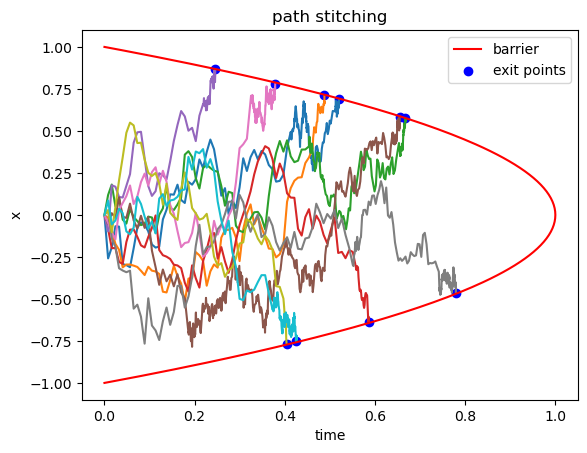

In [44]:
from math import sqrt
import random

def triangle_scale(time,pos):
        xx = sqrt(abs(1-time))- abs(pos)
        tt = abs(1-abs(pos)**2-time)
        return sqrt(tt) if sqrt(tt)<xx else xx

def recursive_para_path_sample(nsim = 10**3,accuracy = 0.1,max_scale = 1):
    path_sample = []
    for _ in range(nsim):
        time,pos= 0,0
        path = [(time,pos)]
        scale = min(triangle_scale(time,pos),max_scale)
        while scale > accuracy:
            dpath = random.sample(t_path_sample,1)[0]
            # sometimes you can get away with only a ptr and the endpoint
            dpath = [(time + (scale**2)*t,pos + scale*p) for t,p in dpath[1:]] 
            time,pos = dpath[-1]
            path += dpath
            scale = min(triangle_scale(time,pos),max_scale)
        path_sample.append(path)
    return path_sample
r_path_sample = recursive_para_path_sample(10**1,0.01,0.9)


for p in r_path_sample:
    x,y = zip(*p)
    plt.plot(x,y)

fp_points = [p[-1] for p in r_path_sample]
x,y = zip(*fp_points)
plt.scatter(x,y,color="blue")

y = np.arange(-1,1.01,0.01)
x = 1-y**2
plt.plot(x,y,color="red",label="barrier")

plt.scatter([],[],color="blue",label="exit points")
plt.title("path stitching")
plt.xlabel("time")
plt.ylabel("x")
plt.legend()
plt.show()

For plotting the path we needed to accesses to all of its points.  An advantage over normally generating paths is that a path can be represented by its subpaths and their scalings requiring way less memory then a full path. This can be useful in case where the whole path isn't needed. Even if  accesses to the whole path is needed this can be done in a slightly more efficient manor then a normal Euler scheme because it can almost be done in parallel vs step for step generation. The only downsides are that the time steps are inhomogeneous and it requires a precomputation. <br>

A way around scaling base samples is limiting scaling to a discrete set and pick the biggest scaling that fits, instead of generating base samples for $1$ scale and scaling it dynamically precompute all the discrete scalings. <br>

Similar precomputing tricks can be used for geometric Brownian motion requiring and extra dimension of precomputing based on transformations.